In [4]:
"""
Recreate Woo et al paper exactly

Author: Alan Nguyen

08-07-2020
"""

'\nRecreate Woo et al paper exactly\n\nAuthor: Alan Nguyen\n\n08-07-2020\n'

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, Column
from scipy.optimize import curve_fit, leastsq
from scipy.stats import spearmanr
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u
import os
import math as m
from astropy import constants as const
import time
from BOSS_func_v9 import *
from general_functions_v1 import *
import matplotlib.patches as mpatches

In [6]:
hdul = fits.open('gal_line_dr7_v5_2.fit')

gal_line = hdul[1].data

hdul.close()

##################################################################################

hdul = fits.open('gal_info_dr7_v5_2.fit')

gal_info = hdul[1].data

hdul.close()

In [7]:
OIII5007_flux     = gal_line['OIII_5007_FLUX']
OIII5007_flux_err = gal_line['OIII_5007_FLUX_ERR']

NII6584_flux     = gal_line['NII_6584_FLUX']
NII6584_flux_err = gal_line['NII_6584_FLUX_ERR']

HBeta_flux     = gal_line['H_BETA_FLUX'] 
HBeta_flux_err = gal_line['H_BETA_FLUX_ERR']

HAlpha_flux     = gal_line['H_ALPHA_FLUX']
HAlpha_flux_err = gal_line['H_ALPHA_FLUX_ERR']

OIII5007_AN = OIII5007_flux / OIII5007_flux_err
NII6584_AN  =  NII6584_flux / NII6584_flux_err
HBeta_AN    =    HBeta_flux / HBeta_flux_err
HAlpha_AN   =   HAlpha_flux / HAlpha_flux_err

HAlpha_cont = gal_line['H_ALPHA_CONT']

HBeta_EW = gal_line['H_BETA_EQW']

##################################################################################

CONT_SN = gal_info['sn_median']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [8]:
z = gal_info['Z']

In [10]:
select_good_data = (OIII5007_AN>=3)&(NII6584_AN>=3)&(HBeta_AN>=3)&(HAlpha_AN>=3)&(CONT_SN>=10)&(z <= 0.6)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


In [11]:
gal_line_good = gal_line[select_good_data]
gal_info_good = gal_info[select_good_data]

In [12]:
len(gal_line_good)

277617

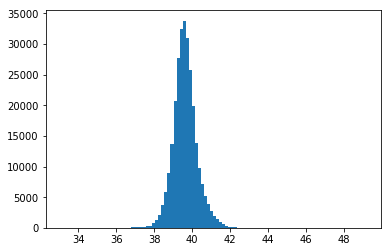

In [21]:
lum_dis = cosmo.luminosity_distance(gal_info_good['Z'])
lum_dis = lum_dis.to(u.cm)
OIII_flux_correct_units = gal_line_good['OIII_5007_FLUX'] * (10**(-17)) * (u.erg/(u.cm*u.cm*u.second))
OIII_lum = 4 * np.pi * OIII_flux_correct_units * (lum_dis ** 2)
array_OIII_lum = np.array(OIII_lum)
log_OIII_lum = np.log10(array_OIII_lum)

plt.hist(log_OIII_lum, bins = 100)
plt.show()

In [77]:
select_OIII_lum = (log_OIII_lum <= 43) & (log_OIII_lum >= 38)

In [78]:
gal_line_OIII = gal_line_good[select_OIII_lum]

In [79]:
len(gal_line_OIII)

275568

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


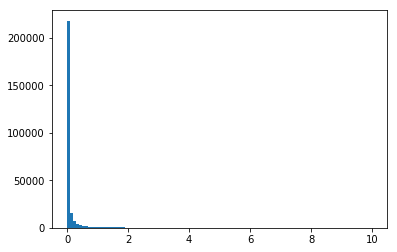

In [28]:
M_sun = 1.9885 * 10 ** 30 # kg
L_sun = 3.8280 * 10 ** 33 # erg/s

sigma_stars = gal_info_good['V_DISP']
sigma_stars_float64 = (sigma_stars).astype('float64')

M_BH = ( 10 ** 8.12 ) * ( ( sigma_stars_float64 / 200 ) ** 4.24 ) * ( M_sun )
lum_edd = ( 3.2 * ( 10 ** 4 ) ) * L_sun * ( M_BH / M_sun )

bol_lum = 3500 * array_OIII_lum

edd_ratio = bol_lum / lum_edd

edd_ratio_good = edd_ratio[(edd_ratio != np.inf) & (edd_ratio < 10)]

plt.hist(edd_ratio_good, bins = 100)
plt.show()

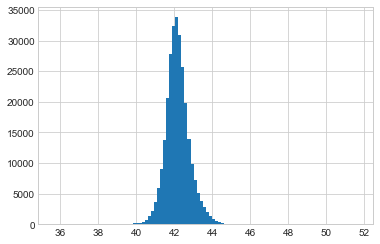

In [60]:
xray_lum = bol_lum / 10

plt.hist(np.log10(xray_lum), bins = 100)
plt.show()

In [61]:
array_summary(xray_lum)

             Count:   277511
              Mean:   6.915077191170717e+46
            Median:   1.384490871944989e+42
Standard Deviation:   9.599677297745647e+48
           Minimum:   4.366362402080643e+35
           Maximum:   4.55040004470784e+51


In [30]:
select_edd = (edd_ratio != np.inf) & (edd_ratio < 10)

In [31]:
gal_line_good = gal_line_good[select_edd]
gal_info_good = gal_info_good[select_edd]

In [32]:
z_good = gal_info_good['Z']

In [33]:
select_bin1 = (0.00<=z_good)&(0.05>z_good)
select_bin2 = (0.05<=z_good)&(0.10>z_good)
select_bin3 = (0.10<=z_good)&(0.20>z_good)
select_bin4 = (0.20<=z_good)&(0.30>z_good)

In [34]:
gal_line_zbin1 = gal_line_good[select_bin1]
gal_line_zbin2 = gal_line_good[select_bin2]
gal_line_zbin3 = gal_line_good[select_bin3]
gal_line_zbin4 = gal_line_good[select_bin4]

gal_info_zbin1 = gal_info_good[select_bin1]
gal_info_zbin2 = gal_info_good[select_bin2]
gal_info_zbin3 = gal_info_good[select_bin3]
gal_info_zbin4 = gal_info_good[select_bin4]

In [36]:
OIII_5007_FLUX_1 = gal_line_zbin1['OIII_5007_FLUX']
NII_6584_FLUX_1  = gal_line_zbin1['NII_6584_FLUX']
H_BETA_FLUX_1    = gal_line_zbin1['H_BETA_FLUX']
H_ALPHA_FLUX_1   = gal_line_zbin1['H_ALPHA_FLUX']

OIII_5007_FLUX_2 = gal_line_zbin2['OIII_5007_FLUX']
NII_6584_FLUX_2  = gal_line_zbin2['NII_6584_FLUX']
H_BETA_FLUX_2    = gal_line_zbin2['H_BETA_FLUX']
H_ALPHA_FLUX_2   = gal_line_zbin2['H_ALPHA_FLUX']

OIII_5007_FLUX_3 = gal_line_zbin3['OIII_5007_FLUX']
NII_6584_FLUX_3  = gal_line_zbin3['NII_6584_FLUX']
H_BETA_FLUX_3    = gal_line_zbin3['H_BETA_FLUX']
H_ALPHA_FLUX_3   = gal_line_zbin3['H_ALPHA_FLUX']

OIII_5007_FLUX_4 = gal_line_zbin4['OIII_5007_FLUX']
NII_6584_FLUX_4  = gal_line_zbin4['NII_6584_FLUX']
H_BETA_FLUX_4    = gal_line_zbin4['H_BETA_FLUX']
H_ALPHA_FLUX_4   = gal_line_zbin4['H_ALPHA_FLUX']

##################################################################################

zbin1_bpt_x =  np.log10(NII_6584_FLUX_1 / H_ALPHA_FLUX_1)
zbin1_bpt_y = np.log10(OIII_5007_FLUX_1 /  H_BETA_FLUX_1)

zbin2_bpt_x =  np.log10(NII_6584_FLUX_2 / H_ALPHA_FLUX_2)
zbin2_bpt_y = np.log10(OIII_5007_FLUX_2 /  H_BETA_FLUX_2)

zbin3_bpt_x =  np.log10(NII_6584_FLUX_3 / H_ALPHA_FLUX_3)
zbin3_bpt_y = np.log10(OIII_5007_FLUX_3 /  H_BETA_FLUX_3)

zbin4_bpt_x =  np.log10(NII_6584_FLUX_4 / H_ALPHA_FLUX_4)
zbin4_bpt_y = np.log10(OIII_5007_FLUX_4 /  H_BETA_FLUX_4)


In [37]:
x1 = np.arange(-2.5, 0.05, 0.01)
x2 = np.arange(-2.5, 0.47, 0.01)
x3 = np.arange(-0.414, 2, 0.001)

line1 = 0.61/(x1 - 0.05) + 1.3 # Kauffman et al. 2003 pure star formation line
line2 = 0.61/(x2 - 0.47) + 1.19 # Kewley et al. 2001 page16 extreme starburst line
line3 = np.zeros(len(x3))

for x in range(len(x3)):
    line3[x] = 0.5

In [38]:
zbin1_bpt_table = np.zeros((len(zbin1_bpt_x), 3))

zbin1_bpt_table[:, 0] = zbin1_bpt_y
zbin1_bpt_table[:, 1] = zbin1_bpt_x

for row in zbin1_bpt_table:
    
    #HII region
    if   ( ( row[0] - 1.3 ) * ( row[1] - 0.05 ) > 0.61 ):
        row[2] = 1
    
    #composite
    elif ( ( row[0] - 1.3 ) * ( row[1] - 0.05 ) < 0.61 ) and ( ( row[0] - 1.19) * ( row[1] - 0.47 ) > 0.61 ):
        row[2] = 2
        
    #LINER
    elif ( ( row[0] - 1.19 ) * ( row[1] - 0.47 ) < 0.61 ) and ( row[0] < 0.5 ):
        row[2] = 3
        
    #seyfert
    elif ( ( row[0] - 1.19 ) * ( row[1] - 0.47 ) < 0.61 ) and ( row[0] > 0.5 ):
        row[2] = 4
        
##################################################################################

zbin2_bpt_table = np.zeros((len(zbin2_bpt_x), 3))

zbin2_bpt_table[:, 0] = zbin2_bpt_y
zbin2_bpt_table[:, 1] = zbin2_bpt_x

for row in zbin2_bpt_table:
    
    #HII region
    if   ( ( row[0] - 1.3 ) * ( row[1] - 0.05 ) > 0.61 ):
        row[2] = 1
    
    #composite
    elif ( ( row[0] - 1.3 ) * ( row[1] - 0.05 ) < 0.61 ) and ( ( row[0] - 1.19) * ( row[1] - 0.47 ) > 0.61 ):
        row[2] = 2
        
    #LINER
    elif ( ( row[0] - 1.19 ) * ( row[1] - 0.47 ) < 0.61 ) and ( row[0] < 0.5 ):
        row[2] = 3
        
    #seyfert
    elif ( ( row[0] - 1.19 ) * ( row[1] - 0.47 ) < 0.61 ) and ( row[0] > 0.5 ):
        row[2] = 4
        
##################################################################################

zbin3_bpt_table = np.zeros((len(zbin3_bpt_x), 3))

zbin3_bpt_table[:, 0] = zbin3_bpt_y
zbin3_bpt_table[:, 1] = zbin3_bpt_x

for row in zbin3_bpt_table:
    
    #HII region
    if   ( ( row[0] - 1.3 ) * ( row[1] - 0.05 ) > 0.61 ):
        row[2] = 1
    
    #composite
    elif ( ( row[0] - 1.3 ) * ( row[1] - 0.05 ) < 0.61 ) and ( ( row[0] - 1.19) * ( row[1] - 0.47 ) > 0.61 ):
        row[2] = 2
        
    #LINER
    elif ( ( row[0] - 1.19 ) * ( row[1] - 0.47 ) < 0.61 ) and ( row[0] < 0.5 ):
        row[2] = 3
        
    #seyfert
    elif ( ( row[0] - 1.19 ) * ( row[1] - 0.47 ) < 0.61 ) and ( row[0] > 0.5 ):
        row[2] = 4
        
##################################################################################

zbin4_bpt_table = np.zeros((len(zbin4_bpt_x), 3))

zbin4_bpt_table[:, 0] = zbin4_bpt_y
zbin4_bpt_table[:, 1] = zbin4_bpt_x

for row in zbin4_bpt_table:
    
    #HII region
    if   ( ( row[0] - 1.3 ) * ( row[1] - 0.05 ) > 0.61 ):
        row[2] = 1
    
    #composite
    elif ( ( row[0] - 1.3 ) * ( row[1] - 0.05 ) < 0.61 ) and ( ( row[0] - 1.19) * ( row[1] - 0.47 ) > 0.61 ):
        row[2] = 2
        
    #LINER
    elif ( ( row[0] - 1.19 ) * ( row[1] - 0.47 ) < 0.61 ) and ( row[0] < 0.5 ):
        row[2] = 3
        
    #seyfert
    elif ( ( row[0] - 1.19 ) * ( row[1] - 0.47 ) < 0.61 ) and ( row[0] > 0.5 ):
        row[2] = 4
        

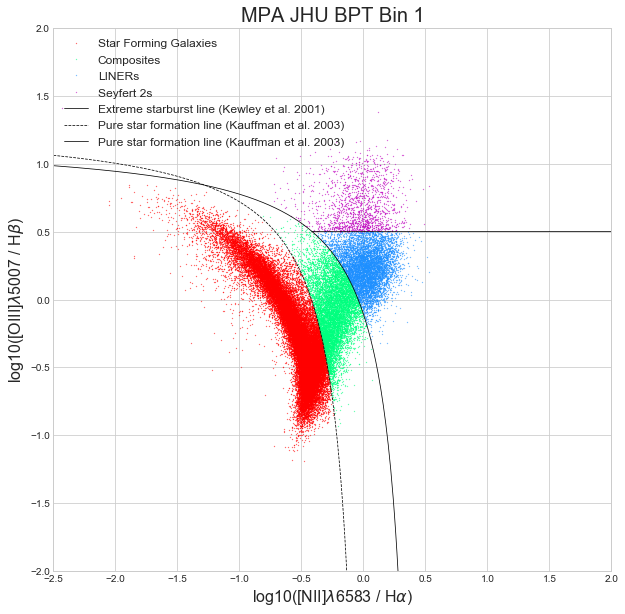

In [39]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10))

#########################################

plt.plot(zbin1_bpt_table[:, 1][zbin1_bpt_table[:, 2] == 1], zbin1_bpt_table[:, 0][zbin1_bpt_table[:, 2] == 1], color = 'r',           linestyle = '', marker = '.', ms = 0.5, label = 'Star Forming Galaxies')
plt.plot(zbin1_bpt_table[:, 1][zbin1_bpt_table[:, 2] == 2], zbin1_bpt_table[:, 0][zbin1_bpt_table[:, 2] == 2], color = 'springgreen', linestyle = '', marker = '.', ms = 0.5, label = 'Composites')
plt.plot(zbin1_bpt_table[:, 1][zbin1_bpt_table[:, 2] == 3], zbin1_bpt_table[:, 0][zbin1_bpt_table[:, 2] == 3], color = 'dodgerblue',  linestyle = '', marker = '.', ms = 0.5, label = 'LINERs')
plt.plot(zbin1_bpt_table[:, 1][zbin1_bpt_table[:, 2] == 4], zbin1_bpt_table[:, 0][zbin1_bpt_table[:, 2] == 4], color = 'm',           linestyle = '', marker = '.', ms = 0.5, label = 'Seyfert 2s')

plt.plot(x2, line2, 'k-', linewidth = 0.75, label = 'Extreme starburst line (Kewley et al. 2001)')
plt.plot(x1, line1, 'k--',  linewidth = 0.75, label = 'Pure star formation line (Kauffman et al. 2003)' )
plt.plot(x3, line3, 'k-',  linewidth = 0.75, label = 'Pure star formation line (Kauffman et al. 2003)' )

plt.xlim(-2.5,2)
plt.ylim(-2,2)

plt.title('MPA JHU BPT Bin 1', fontsize = 20)
plt.ylabel(r'log10([OIII]$\lambda$5007 / H$\beta$)', fontsize = 16)
plt.xlabel(r'log10([NII]$\lambda$6583 / H$\alpha$)', fontsize = 16)
plt.legend(fontsize = 12)

plt.show()

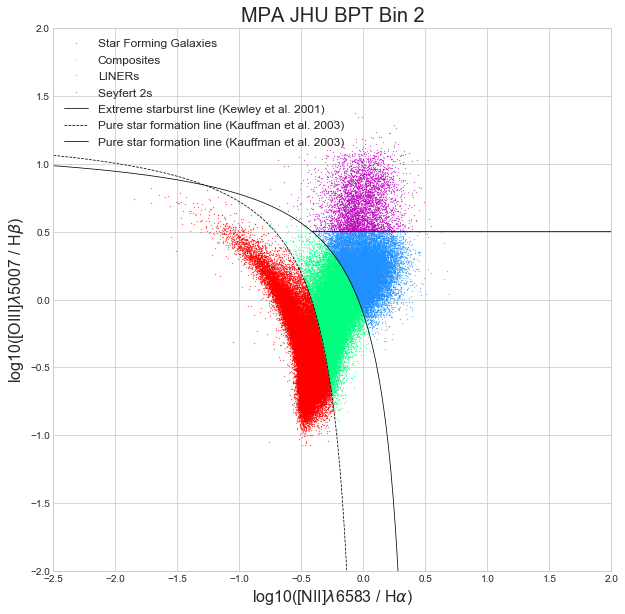

In [40]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10))

#########################################

plt.plot(zbin2_bpt_table[:, 1][zbin2_bpt_table[:, 2] == 1], zbin2_bpt_table[:, 0][zbin2_bpt_table[:, 2] == 1], color = 'r',           linestyle = '', marker = '.', ms = 0.5, label = 'Star Forming Galaxies')
plt.plot(zbin2_bpt_table[:, 1][zbin2_bpt_table[:, 2] == 2], zbin2_bpt_table[:, 0][zbin2_bpt_table[:, 2] == 2], color = 'springgreen', linestyle = '', marker = '.', ms = 0.5, label = 'Composites')
plt.plot(zbin2_bpt_table[:, 1][zbin2_bpt_table[:, 2] == 3], zbin2_bpt_table[:, 0][zbin2_bpt_table[:, 2] == 3], color = 'dodgerblue',  linestyle = '', marker = '.', ms = 0.5, label = 'LINERs')
plt.plot(zbin2_bpt_table[:, 1][zbin2_bpt_table[:, 2] == 4], zbin2_bpt_table[:, 0][zbin2_bpt_table[:, 2] == 4], color = 'm',           linestyle = '', marker = '.', ms = 0.5, label = 'Seyfert 2s')

plt.plot(x2, line2, 'k-', linewidth = 0.75, label = 'Extreme starburst line (Kewley et al. 2001)')
plt.plot(x1, line1, 'k--',  linewidth = 0.75, label = 'Pure star formation line (Kauffman et al. 2003)' )
plt.plot(x3, line3, 'k-',  linewidth = 0.75, label = 'Pure star formation line (Kauffman et al. 2003)' )

plt.xlim(-2.5,2)
plt.ylim(-2,2)

plt.title('MPA JHU BPT Bin 2', fontsize = 20)
plt.ylabel(r'log10([OIII]$\lambda$5007 / H$\beta$)', fontsize = 16)
plt.xlabel(r'log10([NII]$\lambda$6583 / H$\alpha$)', fontsize = 16)
plt.legend(fontsize = 12)

plt.show()

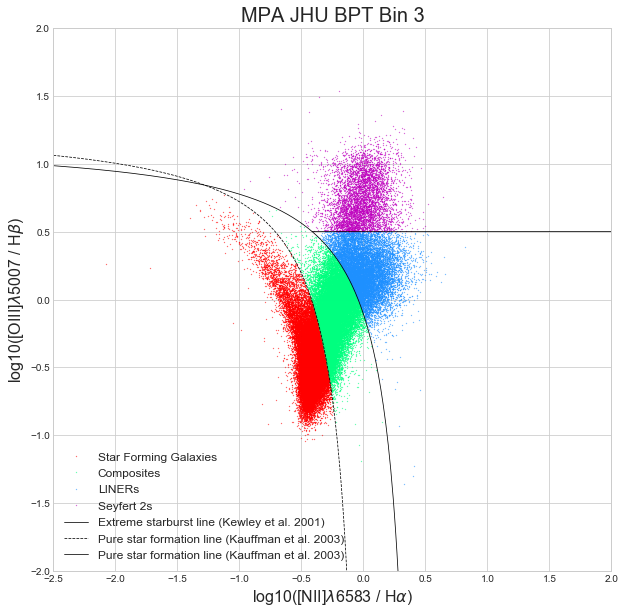

In [41]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10))

#########################################

plt.plot(zbin3_bpt_table[:, 1][zbin3_bpt_table[:, 2] == 1], zbin3_bpt_table[:, 0][zbin3_bpt_table[:, 2] == 1], color = 'r',           linestyle = '', marker = '.', ms = 0.5, label = 'Star Forming Galaxies')
plt.plot(zbin3_bpt_table[:, 1][zbin3_bpt_table[:, 2] == 2], zbin3_bpt_table[:, 0][zbin3_bpt_table[:, 2] == 2], color = 'springgreen', linestyle = '', marker = '.', ms = 0.5, label = 'Composites')
plt.plot(zbin3_bpt_table[:, 1][zbin3_bpt_table[:, 2] == 3], zbin3_bpt_table[:, 0][zbin3_bpt_table[:, 2] == 3], color = 'dodgerblue',  linestyle = '', marker = '.', ms = 0.5, label = 'LINERs')
plt.plot(zbin3_bpt_table[:, 1][zbin3_bpt_table[:, 2] == 4], zbin3_bpt_table[:, 0][zbin3_bpt_table[:, 2] == 4], color = 'm',           linestyle = '', marker = '.', ms = 0.5, label = 'Seyfert 2s')

plt.plot(x2, line2, 'k-', linewidth = 0.75, label = 'Extreme starburst line (Kewley et al. 2001)')
plt.plot(x1, line1, 'k--',  linewidth = 0.75, label = 'Pure star formation line (Kauffman et al. 2003)' )
plt.plot(x3, line3, 'k-',  linewidth = 0.75, label = 'Pure star formation line (Kauffman et al. 2003)' )

plt.xlim(-2.5,2)
plt.ylim(-2,2)

plt.title('MPA JHU BPT Bin 3', fontsize = 20)
plt.ylabel(r'log10([OIII]$\lambda$5007 / H$\beta$)', fontsize = 16)
plt.xlabel(r'log10([NII]$\lambda$6583 / H$\alpha$)', fontsize = 16)
plt.legend(fontsize = 12)

plt.show()

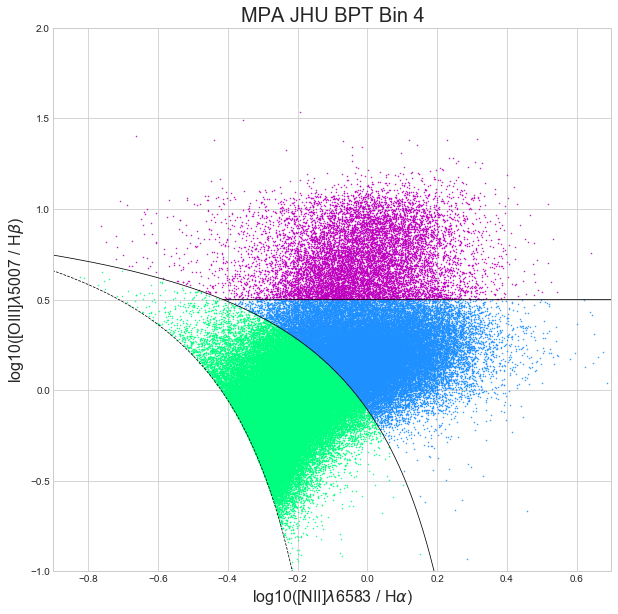

In [42]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10))

#########################################

# plt.plot(zbin1_bpt_table[:, 1][zbin1_bpt_table[:, 2] == 1], zbin1_bpt_table[:, 0][zbin1_bpt_table[:, 2] == 1], color = 'r',           linestyle = '', marker = '.', ms = 0.5, label = 'Star Forming Galaxies')
plt.plot(zbin1_bpt_table[:, 1][zbin1_bpt_table[:, 2] == 2], zbin1_bpt_table[:, 0][zbin1_bpt_table[:, 2] == 2], color = 'springgreen', linestyle = '', marker = '.', ms = 1, label = 'Composites')
plt.plot(zbin1_bpt_table[:, 1][zbin1_bpt_table[:, 2] == 3], zbin1_bpt_table[:, 0][zbin1_bpt_table[:, 2] == 3], color = 'dodgerblue',  linestyle = '', marker = '.', ms = 1, label = 'LINERs')
plt.plot(zbin1_bpt_table[:, 1][zbin1_bpt_table[:, 2] == 4], zbin1_bpt_table[:, 0][zbin1_bpt_table[:, 2] == 4], color = 'm',           linestyle = '', marker = '.', ms = 1, label = 'Seyfert 2s')

# plt.plot(zbin2_bpt_table[:, 1][zbin2_bpt_table[:, 2] == 1], zbin2_bpt_table[:, 0][zbin2_bpt_table[:, 2] == 1], color = 'r',           linestyle = '', marker = '.', ms = 0.5, label = 'Star Forming Galaxies')
plt.plot(zbin2_bpt_table[:, 1][zbin2_bpt_table[:, 2] == 2], zbin2_bpt_table[:, 0][zbin2_bpt_table[:, 2] == 2], color = 'springgreen', linestyle = '', marker = '.', ms = 1, label = 'Composites')
plt.plot(zbin2_bpt_table[:, 1][zbin2_bpt_table[:, 2] == 3], zbin2_bpt_table[:, 0][zbin2_bpt_table[:, 2] == 3], color = 'dodgerblue',  linestyle = '', marker = '.', ms = 1, label = 'LINERs')
plt.plot(zbin2_bpt_table[:, 1][zbin2_bpt_table[:, 2] == 4], zbin2_bpt_table[:, 0][zbin2_bpt_table[:, 2] == 4], color = 'm',           linestyle = '', marker = '.', ms = 1, label = 'Seyfert 2s')

# plt.plot(zbin3_bpt_table[:, 1][zbin3_bpt_table[:, 2] == 1], zbin3_bpt_table[:, 0][zbin3_bpt_table[:, 2] == 1], color = 'r',           linestyle = '', marker = '.', ms = 0.5, label = 'Star Forming Galaxies')
plt.plot(zbin3_bpt_table[:, 1][zbin3_bpt_table[:, 2] == 2], zbin3_bpt_table[:, 0][zbin3_bpt_table[:, 2] == 2], color = 'springgreen', linestyle = '', marker = '.', ms = 1, label = 'Composites')
plt.plot(zbin3_bpt_table[:, 1][zbin3_bpt_table[:, 2] == 3], zbin3_bpt_table[:, 0][zbin3_bpt_table[:, 2] == 3], color = 'dodgerblue',  linestyle = '', marker = '.', ms = 1, label = 'LINERs')
plt.plot(zbin3_bpt_table[:, 1][zbin3_bpt_table[:, 2] == 4], zbin3_bpt_table[:, 0][zbin3_bpt_table[:, 2] == 4], color = 'm',           linestyle = '', marker = '.', ms = 1, label = 'Seyfert 2s')

# plt.plot(zbin4_bpt_table[:, 1][zbin4_bpt_table[:, 2] == 1], zbin4_bpt_table[:, 0][zbin4_bpt_table[:, 2] == 1], color = 'r',           linestyle = '', marker = '.', ms = 0.5, label = 'Star Forming Galaxies')
plt.plot(zbin4_bpt_table[:, 1][zbin4_bpt_table[:, 2] == 2], zbin4_bpt_table[:, 0][zbin4_bpt_table[:, 2] == 2], color = 'springgreen', linestyle = '', marker = '.', ms = 1, label = 'Composites')
plt.plot(zbin4_bpt_table[:, 1][zbin4_bpt_table[:, 2] == 3], zbin4_bpt_table[:, 0][zbin4_bpt_table[:, 2] == 3], color = 'dodgerblue',  linestyle = '', marker = '.', ms = 1, label = 'LINERs')
plt.plot(zbin4_bpt_table[:, 1][zbin4_bpt_table[:, 2] == 4], zbin4_bpt_table[:, 0][zbin4_bpt_table[:, 2] == 4], color = 'm',           linestyle = '', marker = '.', ms = 1, label = 'Seyfert 2s')

plt.plot(x2, line2, 'k-', linewidth = 0.75, label = 'Extreme starburst line (Kewley et al. 2001)')
plt.plot(x1, line1, 'k--',  linewidth = 0.75, label = 'Pure star formation line (Kauffman et al. 2003)' )
plt.plot(x3, line3, 'k-',  linewidth = 0.75, label = 'Pure star formation line (Kauffman et al. 2003)' )

plt.xlim(-0.9,0.7)
plt.ylim(-1,2)

plt.title('MPA JHU BPT Bin 4', fontsize = 20)
plt.ylabel(r'log10([OIII]$\lambda$5007 / H$\beta$)', fontsize = 16)
plt.xlabel(r'log10([NII]$\lambda$6583 / H$\alpha$)', fontsize = 16)
# plt.legend(fontsize = 12)

plt.show()

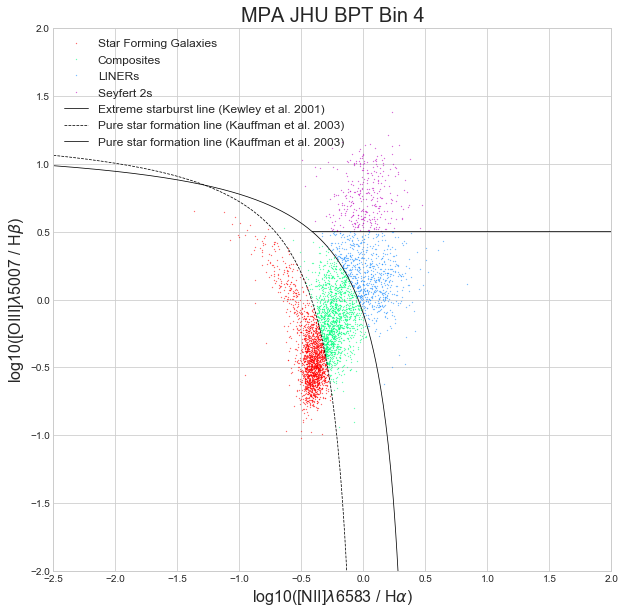

In [43]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10))

#########################################

plt.plot(zbin4_bpt_table[:, 1][zbin4_bpt_table[:, 2] == 1], zbin4_bpt_table[:, 0][zbin4_bpt_table[:, 2] == 1], color = 'r',           linestyle = '', marker = '.', ms = 0.5, label = 'Star Forming Galaxies')
plt.plot(zbin4_bpt_table[:, 1][zbin4_bpt_table[:, 2] == 2], zbin4_bpt_table[:, 0][zbin4_bpt_table[:, 2] == 2], color = 'springgreen', linestyle = '', marker = '.', ms = 0.5, label = 'Composites')
plt.plot(zbin4_bpt_table[:, 1][zbin4_bpt_table[:, 2] == 3], zbin4_bpt_table[:, 0][zbin4_bpt_table[:, 2] == 3], color = 'dodgerblue',  linestyle = '', marker = '.', ms = 0.5, label = 'LINERs')
plt.plot(zbin4_bpt_table[:, 1][zbin4_bpt_table[:, 2] == 4], zbin4_bpt_table[:, 0][zbin4_bpt_table[:, 2] == 4], color = 'm',           linestyle = '', marker = '.', ms = 0.5, label = 'Seyfert 2s')

plt.plot(x2, line2, 'k-', linewidth = 0.75, label = 'Extreme starburst line (Kewley et al. 2001)')
plt.plot(x1, line1, 'k--',  linewidth = 0.75, label = 'Pure star formation line (Kauffman et al. 2003)' )
plt.plot(x3, line3, 'k-',  linewidth = 0.75, label = 'Pure star formation line (Kauffman et al. 2003)' )

plt.xlim(-2.5,2)
plt.ylim(-2,2)

plt.title('MPA JHU BPT Bin 4', fontsize = 20)
plt.ylabel(r'log10([OIII]$\lambda$5007 / H$\beta$)', fontsize = 16)
plt.xlabel(r'log10([NII]$\lambda$6583 / H$\alpha$)', fontsize = 16)
plt.legend(fontsize = 12)

plt.show()

In [46]:
select_zbin1_seyferts = (zbin1_bpt_table[:, 2] == 4)
select_zbin1_liner    = (zbin1_bpt_table[:, 2] == 3)

select_zbin2_seyferts = (zbin2_bpt_table[:, 2] == 4)
select_zbin2_liner    = (zbin2_bpt_table[:, 2] == 3)

select_zbin3_seyferts = (zbin3_bpt_table[:, 2] == 4)
select_zbin3_liner    = (zbin3_bpt_table[:, 2] == 3)

select_zbin4_seyferts = (zbin4_bpt_table[:, 2] == 4)
select_zbin4_liner    = (zbin4_bpt_table[:, 2] == 3)

In [50]:
gal_info_zbin1_1 = gal_info_zbin1[select_zbin1_seyferts | select_zbin1_liner ]
gal_info_zbin2_1 = gal_info_zbin2[select_zbin2_seyferts | select_zbin2_liner ]
gal_info_zbin3_1 = gal_info_zbin3[select_zbin3_seyferts | select_zbin3_liner ]
gal_info_zbin4_1 = gal_info_zbin4[select_zbin4_seyferts | select_zbin4_liner ]

In [51]:
len(gal_info_zbin1_1) + len(gal_info_zbin2_1) + len(gal_info_zbin3_1) + len(gal_info_zbin4_1)

49443

In [45]:
gal_line_sf_zbin1 = gal_line_zbin1[select_zbin1_seyferts]
gal_line_sf_zbin2 = gal_line_zbin2[select_zbin2_seyferts]
gal_line_sf_zbin3 = gal_line_zbin3[select_zbin3_seyferts]
gal_line_sf_zbin4 = gal_line_zbin4[select_zbin4_seyferts]

gal_info_sf_zbin1 = gal_info_zbin1[select_zbin1_seyferts]
gal_info_sf_zbin2 = gal_info_zbin2[select_zbin2_seyferts]
gal_info_sf_zbin3 = gal_info_zbin3[select_zbin3_seyferts]
gal_info_sf_zbin4 = gal_info_zbin4[select_zbin4_seyferts]

In [126]:
# Table(gal_line_sf_zbin1).write('gal_line_zbin1.fits')
# Table(gal_line_sf_zbin2).write('gal_line_zbin2.fits')
# Table(gal_line_sf_zbin3).write('gal_line_zbin3.fits')
# Table(gal_line_sf_zbin4).write('gal_line_zbin4.fits')

In [127]:
# Table(gal_info_sf_zbin1).write('gal_info_zbin1.fits')
# Table(gal_info_sf_zbin2).write('gal_info_zbin2.fits')
# Table(gal_info_sf_zbin3).write('gal_info_zbin3.fits')
# Table(gal_info_sf_zbin4).write('gal_info_zbin4.fits')